# Patient Selection

The purpose of this notebook is to generate a list of patient ICU stays that meet the following criteria:
- patient is at least 16 years old.
- ICU stay lasts at least 24 hours.
- ICU stay is the first ICU admission for that patient.
- patient was mechanically ventilated at least once.

Two pandas DataFrames are created and saved in **"data/patients.npy"**.

The column names in ***patients*** are:
- **subject_id** - patient identifier.
- **hadm_id** - hospital admission identifier.
- **icustay_id** - ICU admission identifier.
- **gender, dob, age** - self-explanatory.
- **admittime, dischtime** - time of hospital admission and discharge.
- **intime, outtime** - time of ICU admission and discharge.
- **los** - length of ICU stay in days.
- **diagnosis** - free text diagnosis usually assigned by the admitting clinician.
- **hospital_expire_flag** - whether the patient died during that hospital stay or not.
- **ventnum** - the number of times they were placed on mechanical ventilation.

The column names in ***mech_vent*** are:
- **icustay_id** - ICU admission identifier.
- **ventnum** - a counter for the number of instances of mechanical ventilation for that ICU stay (1 is the patient's first time on a ventilator, 2 is the second, etc.).
- **starttime, endtime** - time at which the patient was intubated and extubated.
- **duration_hours** - the duration of that instance of mechanical ventilation.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Load the appropriate query
query = open('queries/icu_patients.sql', 'r')

# Store the result of the query as a pandas dataframe
icu = pd.read_sql_query(query.read(), conn)
query.close()

In [4]:
# Show some sample data
icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,los,diagnosis,hospital_expire_flag
0,2,163353,243653,M,2138-07-17,0.00,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918,NEWBORN,0
1,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0
2,4,185777,294638,F,2143-05-12,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,214757,M,2103-02-02,0.00,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844,NEWBORN,0
4,6,107064,228232,F,2109-06-21,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,CHRONIC RENAL FAILURE/SDA,0


In [5]:
# Print some statistics about the patient population
print('No. of patients: {}'.format(len(np.unique(icu['subject_id']))))
print('No. of hospital admissions: {}'.format(len(np.unique(icu['hadm_id']))))
print('No. of ICU admissions: {}'.format(len(np.unique(icu['icustay_id']))))

No. of patients: 46476
No. of hospital admissions: 57786
No. of ICU admissions: 61532


In [6]:
# Remove any patients under 16 years old
adult_icu = icu[icu['age']>=16]
print('Removed {} patients under 16 years old (corresponding to {} hospital admissions and {} ICU stays)'.format(len(np.unique(icu['subject_id']))-len(np.unique(adult_icu['subject_id'])), len(np.unique(icu['hadm_id']))-len(np.unique(adult_icu['hadm_id'])), len(np.unique(icu['icustay_id']))-len(np.unique(adult_icu['icustay_id']))))

Removed 7879 patients under 16 years old (corresponding to 8001 hospital admissions and 8109 ICU stays)


In [7]:
# Remove any patients with ICU stays under 24 hours
adult_24h_icu = adult_icu[adult_icu['los']>=1]
print('Removed {} patients with ICU stays lasting less than 24 hours (corresponding to {} hospital admissions and {} ICU stays)'.format(len(np.unique(adult_icu['subject_id']))-len(np.unique(adult_24h_icu['subject_id'])), len(np.unique(adult_icu['hadm_id']))-len(np.unique(adult_24h_icu['hadm_id'])), len(np.unique(adult_icu['icustay_id']))-len(np.unique(adult_24h_icu['icustay_id']))))

Removed 4972 patients with ICU stays lasting less than 24 hours (corresponding to 7222 hospital admissions and 8102 ICU stays)


In [8]:
# Select first ICU admission for each patient
icu_sorted = adult_24h_icu.sort_values(by=['subject_id', 'intime']) # sort patients by subject ID and ICU admission time
adult_24h_first_icu = icu_sorted.groupby('subject_id', as_index=False).first() # take the first ICU admission for each subject
print('Removed {} ICU stays that were not the first ICU admission for that patient'.format(len(np.unique(adult_24h_icu['icustay_id']))-len(np.unique(adult_24h_first_icu['icustay_id']))))

Removed 11696 ICU stays that were not the first ICU admission for that patient


In [9]:
# Load the mechanical ventilation query
query = open('queries/mechanical_ventilation.sql', 'r')

# Store the result of the query as a pandas dataframe
mech_vent = pd.read_sql_query(query.read(), conn)
query.close()

In [10]:
# Show some sample data
mech_vent.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
0,200003.0,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,200006.0,1,2159-09-03 13:00:00,2159-09-04 03:50:00,14.833333
2,200009.0,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,200011.0,1,2188-08-06 01:00:00,2188-08-06 04:00:00,3.000000
4,200014.0,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000


In [11]:
# Remove missing ICU stay IDs
num_missing = sum(mech_vent['icustay_id'].isna())
mech_vent = mech_vent.dropna(subset=['icustay_id'])
print("Removed {} rows with missing ICU stay IDs".format(num_missing))

Removed 34 rows with missing ICU stay IDs


In [12]:
# Select ventilation information only for patients who meet our criteria
mech_vent_patients = mech_vent[mech_vent['icustay_id'].isin(adult_24h_first_icu['icustay_id'])]
print("Removed {} ICU stays that don't meet the criteria above (corresponding to {} instances of mechanical ventilation)".format(len(np.unique(mech_vent['icustay_id']))-len(np.unique(mech_vent_patients['icustay_id'])), len(mech_vent['icustay_id'])-len(mech_vent_patients['icustay_id'])))

Removed 8612 ICU stays that don't meet the criteria above (corresponding to 12872 instances of mechanical ventilation)


In [13]:
# Remove patients who were not mechanically ventilated
adult_24h_first_icu_mv = adult_24h_first_icu[adult_24h_first_icu['icustay_id'].isin(mech_vent_patients['icustay_id'])]
print('Removed {} ICU stays where mechanical ventilation was not used'.format(len(np.unique(adult_24h_first_icu['icustay_id']))-len(np.unique(adult_24h_first_icu_mv['icustay_id']))))

Removed 15436 ICU stays where mechanical ventilation was not used


In [14]:
# Add a column describing the number of times a patient was ventilated
adult_24h_first_icu_mv = adult_24h_first_icu_mv.merge(mech_vent_patients.groupby(['icustay_id']).max()['ventnum'], on='icustay_id')

In [15]:
# Show some sample data for adult first ICU admission
adult_24h_first_icu_mv.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,los,diagnosis,hospital_expire_flag,ventnum
0,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0,1
1,9,150750,220597,M,2108-01-26,41.79,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,HEMORRHAGIC CVA,1,1
2,12,112213,232669,M,2032-03-24,72.37,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-08 02:08:17,2104-08-15 17:22:25,7.6348,PANCREATIC CANCER/SDA,1,1
3,13,143045,263738,F,2127-02-27,39.86,2167-01-08 18:43:00,2167-01-15 15:15:00,2167-01-08 18:44:25,2167-01-12 10:43:31,3.6660,CORONARY ARTERY DISEASE,0,1
4,17,194023,277042,F,2087-07-14,47.45,2134-12-27 07:15:00,2134-12-31 16:05:00,2134-12-27 16:21:48,2134-12-29 18:04:03,2.0710,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,0,1


In [16]:
# Print some statistics about the processed patient population
print("No. of instances of mechanical ventilation: {}".format(len(mech_vent_patients['icustay_id'])))
print('No. of patients: {}'.format(len(np.unique(adult_24h_first_icu_mv['subject_id']))))
print('No. of hospital admissions: {}'.format(len(np.unique(adult_24h_first_icu_mv['hadm_id']))))
print('No. of ICU admissions: {}'.format(len(np.unique(adult_24h_first_icu_mv['icustay_id']))))

No. of instances of mechanical ventilation: 25602
No. of patients: 18189
No. of hospital admissions: 18189
No. of ICU admissions: 18189


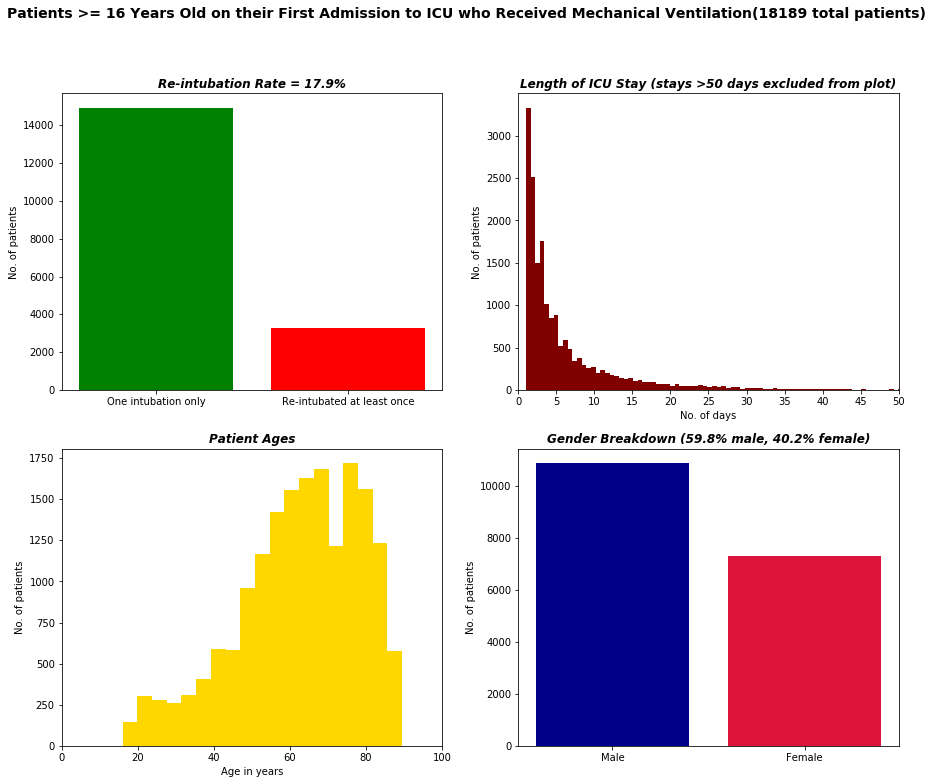

In [17]:
# Visualise re-intubation rate,length of ICU stay, age and gender
fig, axs = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Patients >= 16 Years Old on their First Admission to ICU who Received Mechanical Ventilation({} total patients)'.format(len(adult_24h_first_icu_mv)), weight='semibold', fontsize=14)

# Plot the mortality
axs[0,0].bar(x=['One intubation only','Re-intubated at least once'], height=[len(adult_24h_first_icu_mv)-sum(adult_24h_first_icu_mv['ventnum']>1),sum(adult_24h_first_icu_mv['ventnum']>1)], color=['g','r'])
axs[0,0].set_title('Re-intubation Rate = {:.1f}%'.format(100*sum(adult_24h_first_icu_mv['ventnum']>1)/len(adult_24h_first_icu_mv)), style='italic', weight='semibold')
axs[0,0].set_ylabel('No. of patients')

# Plot the length of stay
axs[0,1].hist(x=adult_24h_first_icu_mv['los'], bins=250, color='maroon')
axs[0,1].set_title('Length of ICU Stay (stays >50 days excluded from plot)', style='italic', weight='semibold')
axs[0,1].set_xlim([0,50])
axs[0,1].set_xticks(range(0,51,5))
axs[0,1].set_xlabel('No. of days')
axs[0,1].set_ylabel('No. of patients')

# Plot the patient ages
axs[1,0].hist(x=adult_24h_first_icu_mv['age'].astype('int64'), bins=75, color='gold')
axs[1,0].set_title('Patient Ages', style='italic', weight='semibold')
axs[1,0].set_xlim([0,100])
axs[1,0].set_xlabel('Age in years')
axs[1,0].set_ylabel('No. of patients')

# Plot the gender breakdown
axs[1,1].bar(x=['Male','Female'], height=[sum(adult_24h_first_icu_mv['gender']=='M'),sum(adult_24h_first_icu_mv['gender']=='F')], color=['darkblue','crimson'])
axs[1,1].set_title('Gender Breakdown ({:.1f}% male, {:.1f}% female)'.format(100*sum(adult_24h_first_icu_mv['gender']=='M')/len(adult_24h_first_icu_mv), 100*sum(adult_24h_first_icu_mv['gender']=='F')/len(adult_24h_first_icu_mv)), style='italic', weight='semibold')
axs[1,1].set_ylabel('No. of patients');

In [18]:
# Sort patients by subject_id, then hadm_id and icustay_id
adult_24h_first_icu_mv.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'])

# Save to patients.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'patients': adult_24h_first_icu_mv, 'mech_vent': mech_vent_patients}
np.save('data/patients.npy',tosave)
print("Saved!")

Saved!
